In [1]:
from graph_var.utils import load_graph_from_pkl
from graph_var.graph import PangenomeGraph
from graph_var.evaluating_functions import *
import pandas as pd

In [10]:
wavevcf = True

if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_list = ["variant_summary_with_NIA_flag", "variant_region_summary", 
               "snp_region_summary", "snp_ac_range_summary", "variant_ourvcf_vs_vcfwave"]

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets = {k: v for k, v in sheets.items() if k in sheet_list}

if wavevcf:
    file_path_filter = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave_clear.xlsx'
else:
    file_path_filter = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw_clear.xlsx'

with pd.ExcelWriter(file_path_filter, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

In [3]:
graph_obj_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Graph_objs'
raw_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_chr'
graph_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf'

gfa_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chromosome_gfa'
snarl_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chr_snarls'
bubble_summary_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_summary"
bubble_result_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_result_update"

mode = 'AT'
wavevcf = True

In [3]:
def variant_edges_summary_from_dict(var_list: list, var_dict: dict):
    summary_dict = dict()
    for edge in sorted(list(var_list)):
        summary_dict[var_dict[edge]] = summary_dict.get(var_dict[edge], 0) + 1
    summary_dict['total'] = len(var_list)
    return summary_dict

def prepare_dataframe_dict(var_dict):
    return pd.DataFrame({
        "Variant Type": ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total'],
        "Count": [
                  var_dict.get('snp', 0),
                  var_dict.get('mnp', 0),
                  var_dict.get('insertion', 0),
                  var_dict.get('deletion', 0),
                  var_dict.get('replacement', 0),
                  var_dict.get('inversion', 0),
                  var_dict.get('repeat', 0),
                  var_dict.get('total', 0),
        ]
    })

In [4]:
for i in range(1, 23):
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    if wavevcf:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{i}.vcf"
    else:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_chr{i}.vcf"
    print(f"Processing file: {graph_vcf_path}")
    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)

    variants = []

    linear_variants = []
    non_linear_variants = []

    small_variants = []
    large_variants = []

    common_variants = []
    uncommon_variants = []

    linear_small_variants = []
    linear_large_variants = []
    non_linear_small_variants = []
    non_linear_large_variants = []

    linear_common_variants = []
    linear_uncommon_variants = []
    non_linear_common_variants = []
    non_linear_uncommon_variants = []

    small_common_variants = []
    small_uncommon_variants = []
    large_common_variants = []
    large_uncommon_variants = []

    linear_small_common_variants = []
    linear_large_common_variants = []
    linear_small_uncommon_variants = []
    linear_large_uncommon_variants = []

    non_linear_small_common_variants = []
    non_linear_large_common_variants = []
    non_linear_small_uncommon_variants = []
    non_linear_large_uncommon_variants = []

    var_dict = {}

    for k in range(len(graph_vcf_df)):
        row = graph_vcf_df.iloc[k]
        edge = eval(row['ID'])
        info = row['INFO']
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in info.split(';') if '=' in attr}
        var_type = info_dict['VT']
        nearly_identical = info_dict.get('NIA', 0)
        ref_ac, alt_ac = int(info_dict['RC']), int(info_dict['AC'])
        allele_length = len(row['REF']) + len(row['ALT'])

        var_dict[edge] = var_type

        on_linear = (int(info_dict['DR'].split(',')[1]) == 0)

        variants.append(edge)

        if on_linear:
            linear_variants.append(edge)
        else:
            non_linear_variants.append(edge)
        
        if allele_length < 50 or nearly_identical:
            small_variants.append(edge)
        else:
            large_variants.append(edge)
        
        if min(ref_ac, alt_ac) > 5:
            common_variants.append(edge)
        else:
            uncommon_variants.append(edge)
        
        if on_linear and (allele_length < 50 or nearly_identical):
            linear_small_variants.append(edge)
        elif on_linear and allele_length >= 50:
            linear_large_variants.append(edge)
        elif not on_linear and (allele_length < 50 or nearly_identical):
            non_linear_small_variants.append(edge)
        elif not on_linear and allele_length >= 50:
            non_linear_large_variants.append(edge)
        else:
            raise ValueError("Unexpected case.")
        
        if on_linear and min(ref_ac, alt_ac) > 5:
            linear_common_variants.append(edge)
        elif on_linear and min(ref_ac, alt_ac) <= 5:
            linear_uncommon_variants.append(edge)
        elif not on_linear and min(ref_ac, alt_ac) > 5:
            non_linear_common_variants.append(edge)
        elif not on_linear and min(ref_ac, alt_ac) <= 5:
            non_linear_uncommon_variants.append(edge)
        else:
            raise ValueError("Unexpected case.")
        
        if (allele_length < 50 or nearly_identical) and min(ref_ac, alt_ac) > 5:
            small_common_variants.append(edge)
        elif (allele_length < 50 or nearly_identical) and min(ref_ac, alt_ac) <= 5:
            small_uncommon_variants.append(edge)
        elif allele_length >= 50 and min(ref_ac, alt_ac) > 5:
            large_common_variants.append(edge)
        elif allele_length >= 50 and min(ref_ac, alt_ac) <= 5:
            large_uncommon_variants.append(edge)
        else:
            raise ValueError("Unexpected case.")

        if on_linear and (allele_length < 50 or nearly_identical) and min(ref_ac, alt_ac) > 5:
            linear_small_common_variants.append(edge)
        elif on_linear and allele_length >= 50 and min(ref_ac, alt_ac) > 5:
            linear_large_common_variants.append(edge)
        elif on_linear and (allele_length < 50 or nearly_identical) and min(ref_ac, alt_ac) <= 5:
            linear_small_uncommon_variants.append(edge)
        elif on_linear and allele_length >= 50 and min(ref_ac, alt_ac) <= 5:
            linear_large_uncommon_variants.append(edge)
        elif not on_linear and (allele_length < 50 or nearly_identical) and min(ref_ac, alt_ac) > 5:
            non_linear_small_common_variants.append(edge)
        elif not on_linear and allele_length >= 50 and min(ref_ac, alt_ac) > 5:
            non_linear_large_common_variants.append(edge)
        elif not on_linear and (allele_length < 50 or nearly_identical) and min(ref_ac, alt_ac) <= 5:
            non_linear_small_uncommon_variants.append(edge)
        elif not on_linear and allele_length >= 50 and min(ref_ac, alt_ac) <= 5:
            non_linear_large_uncommon_variants.append(edge)
        else:
            raise ValueError("Unexpected case.")
    
    var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(variants, var_dict))

    linear_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_variants, var_dict))
    non_linear_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_variants, var_dict))

    small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_variants, var_dict))
    large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_variants, var_dict))

    common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(common_variants, var_dict))
    uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(uncommon_variants, var_dict))

    linear_small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_variants, var_dict))
    linear_large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_variants, var_dict))
    non_linear_small_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_variants, var_dict))
    non_linear_large_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_variants, var_dict))

    linear_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_common_variants, var_dict))
    linear_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_uncommon_variants, var_dict))
    non_linear_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_common_variants, var_dict))
    non_linear_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_uncommon_variants, var_dict))

    small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_common_variants, var_dict))
    small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(small_uncommon_variants, var_dict))
    large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_common_variants, var_dict))
    large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(large_uncommon_variants, var_dict))

    linear_small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_common_variants, var_dict))
    linear_large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_common_variants, var_dict))
    linear_small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_small_uncommon_variants, var_dict))
    linear_large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(linear_large_uncommon_variants, var_dict))

    non_linear_small_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_common_variants, var_dict))
    non_linear_large_common_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_common_variants, var_dict))
    non_linear_small_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_small_uncommon_variants, var_dict))
    non_linear_large_uncommon_var_df = prepare_dataframe_dict(variant_edges_summary_from_dict(non_linear_large_uncommon_variants, var_dict))

    comp_var_summary = pd.DataFrame(
        {
        "CHROM": [f'chr{i}']*len(var_df),

        "Variant Type": var_df['Variant Type'], 
        "All_Variants": var_df['Count'],

        "Linear_Variants": linear_var_df['Count'], 
        "Non_Linear_Variants": non_linear_var_df['Count'], 

        "Small_Variants": small_var_df['Count'], 
        "Large_Variants": large_var_df['Count'], 

        "Common_Variants": common_var_df['Count'], 
        "Uncommon_Variants": uncommon_var_df['Count'], 

        "Linear_Small_Variants": linear_small_var_df['Count'], 
        "Linear_Large_Variants": linear_large_var_df['Count'], 
        "Non_Linear_Small_Variants": non_linear_small_var_df['Count'],  
        "Non_Linear_Large_Variants": non_linear_large_var_df['Count'], 

        "Linear_Common_Variants": linear_common_var_df['Count'], 
        "Linear_Uncommon_Variants": linear_uncommon_var_df['Count'], 
        "Non_Linear_Common_Variants": non_linear_common_var_df['Count'],  
        "Non_Linear_Uncommon_Variants": non_linear_uncommon_var_df['Count'],

        "Small_Common_Variants": small_common_var_df['Count'], 
        "Small_Uncommon_Variants": small_uncommon_var_df['Count'], 
        "Large_Common_Variants": large_common_var_df['Count'],  
        "Large_Uncommon_Variants": large_uncommon_var_df['Count'], 

        "Linear_Small_Common_Variants": linear_small_common_var_df['Count'], 
        "Linear_Large_Common_Variants": linear_large_common_var_df['Count'], 
        "Linear_Small_Uncommon_Variants": linear_small_uncommon_var_df['Count'],  
        "Linear_Large_Uncommon_Variants": linear_large_uncommon_var_df['Count'],

        "Non_Linear_Small_Common_Variants": non_linear_small_common_var_df['Count'], 
        "Non_Linear_Large_Common_Variants": non_linear_large_common_var_df['Count'], 
        "Non_Linear_Small_Uncommon_Variants": non_linear_small_uncommon_var_df['Count'],  
        "Non_Linear_Large_Uncommon_Variants": non_linear_large_uncommon_var_df['Count'], 
        }
    )
    comp_var_summary.to_csv(f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr/comprehensive_variant_summary_for_chr{i}.csv", index=False)

Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf/graph_chr1_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf/graph_chr2_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf/graph_chr3_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf/graph_chr4_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf/graph_chr5_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf/graph_chr6_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf/graph_chr7_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update/flag_NIA_vcf/graph_chr8_no_terminus.vcf
Processing file: /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_upd

In [5]:
import pandas as pd

graph_vcf_summary_df_list = []

for i in range(1, 23):
    graph_vcf_summary_df = pd.read_csv(f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr/comprehensive_variant_summary_for_chr{i}.csv")
    graph_vcf_summary_df_list.append(graph_vcf_summary_df)

def sum_up_dfs(df_list, num_id):
    combined = df_list[0].copy()
    for df in df_list[1:]:
        combined.iloc[:, num_id:] += df.iloc[:, num_id:]
    
    return combined

graph_vcf_all_df = sum_up_dfs(graph_vcf_summary_df_list, 2)
graph_vcf_all_df['CHROM'] = 'all'

graph_vcf_summary_df_list.append(graph_vcf_all_df)
graph_vcf_summary_concated_df = pd.concat(graph_vcf_summary_df_list)

In [6]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_name = "variant_summary_with_NIA_flag"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = graph_vcf_summary_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

In [6]:
# for i in range(1, 23):
#     print(f"Processing chr{i}......")
#     if wavevcf:
#         raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{i}.vcf"
#     else:
#         raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_chr{i}.vcf"
#     raw_vcf_df = read_vcf_to_dataframe(raw_vcf_path)

#     def split_vcf_row_minimal(row):
#         ACs = row['INFO'].split(';')[0].split('=')[1].split(',')
#         alts = row['ALT'].split(',')
#         return [{key if key != 'INFO' else 'AC': row[key] if key != 'ALT' and key != 'INFO' else alt if key == 'ALT' else AC \
#             for key in row.keys()} for alt, AC in zip(alts, ACs)]

#     split_rows = []
#     for m in tqdm(range(len(raw_vcf_df))):
#         split_rows.extend(split_vcf_row_minimal(raw_vcf_df.iloc[m]))

#     split_raw_vcf_df = pd.DataFrame(split_rows)

#     sample_cols = split_raw_vcf_df.columns[9:]

#     small_variants = 0
#     large_variants = 0

#     common_variants = 0
#     uncommon_variants = 0

#     small_common_variants = 0
#     small_uncommon_variants = 0
#     large_common_variants = 0
#     large_uncommon_variants = 0

#     for j in range(len(split_raw_vcf_df)):
#         row = split_raw_vcf_df.iloc[j]
        
#         allele_count = int(row['AC'])
#         allele_length = len(row['REF'])+len(row['ALT'])

#         if allele_length < 50:
#             small_variants += 1
#         else:
#             large_variants += 1
        
#         if allele_count > 5:
#             common_variants += 1
#         else:
#             uncommon_variants += 1
        
#         if allele_length < 50 and allele_count > 5:
#             small_common_variants += 1
#         elif allele_length < 50 and allele_count <= 5:
#             small_uncommon_variants += 1
#         elif allele_length >= 50 and allele_count > 5:
#             large_common_variants += 1
#         elif allele_length >= 50 and allele_count <= 5:
#             large_uncommon_variants += 1
#         else:
#             raise ValueError("Unexpected case.")

#     raw_vcf_summary_df = pd.DataFrame({
#         'CHROM': [f"chr{i}"], 
#         'Small_Variants': [small_variants], 
#         'Large_Variants': [large_variants], 
#         'Common_Variants': [common_variants], 
#         'Uncommon_Variants': [uncommon_variants], 
#         'Small_Common_Variants': [small_common_variants], 
#         'Small_Uncommon_Variants': [small_uncommon_variants], 
#         'Large_Common_Variants': [large_common_variants],  
#         'Large_Uncommon_Variants': [large_uncommon_variants]
#     })

#     raw_vcf_summary_df.to_csv(f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr/raw_vcf_summary_chr{i}.csv")          

In [7]:
# import pandas as pd

# raw_vcf_summary_df_list = []

# for i in range(1, 23):
#     raw_vcf_summary_df = pd.read_csv(f"/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_chr/raw_vcf_summary_chr{i}.csv")
#     raw_vcf_summary_df_list.append(raw_vcf_summary_df)

# def sum_up_dfs(df_list, num_id):
#     combined = df_list[0].copy()
#     for df in df_list[1:]:
#         combined.iloc[:, num_id:] += df.iloc[:, num_id:]
    
#     return combined

# raw_vcf_all_df = sum_up_dfs(raw_vcf_summary_df_list, 2)
# raw_vcf_all_df['CHROM'] = 'all'

# raw_vcf_summary_df_list.append(raw_vcf_all_df)
# raw_vcf_summary_concated_df = pd.concat(raw_vcf_summary_df_list)

In [4]:
graph_obj_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Graph_objs'
raw_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_chr'
graph_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update'
stats_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Stats_update'
ac_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_result_update'

In [5]:
other_difficult_bed = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Region_files/GRCh38_subtract_difficult_segdup.bed"
easy_bed = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Region_files/GRCh38_notinalldifficultregions.bed"
segdup_bed = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Region_files/GRCh38_segdups.bed"

In [8]:
df_list = []
for i in range(1,23):
    ac_df_path = f"{ac_dir}/bubble_allele_summary_chr{i}.tsv"
    ac_df = pd.read_csv(ac_df_path, sep='\t')
    df_list.append(ac_df)

allele_count_concated_df = pd.concat(df_list)

In [6]:
def get_df_from_vcf_filtered_by_region(chr_id, raw_vcf=True, graph_vcf=True):
    if wavevcf:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_{chr_id}.vcf"
    else:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_{chr_id}.vcf"
    graph_vcf_path = f"{graph_vcf_dir}/graph_{chr_id}_no_terminus.vcf"

    easy_region = get_interval_tree_from_bed(easy_bed, chr_id)
    segdup_region = get_interval_tree_from_bed(segdup_bed, chr_id)
    diff_region = get_interval_tree_from_bed(other_difficult_bed, chr_id)

    if raw_vcf:
        raw_vcf_df = read_vcf_to_dataframe(raw_vcf_path)
        
        def split_vcf_row_minimal(row):
            ACs = row['INFO'].split(';')[0].split('=')[1].split(',')
            alts = row['ALT'].split(',')
            return [{key if key != 'INFO' else 'AC': row[key] if key != 'ALT' and key != 'INFO' else alt if key == 'ALT' else AC \
                for key in row.keys()} for alt, AC in zip(alts, ACs)]

        split_rows = []
        for i in tqdm(range(len(raw_vcf_df))):
            split_rows.extend(split_vcf_row_minimal(raw_vcf_df.iloc[i]))

        split_raw_vcf_df = pd.DataFrame(split_rows)

        split_raw_vcf_df = split_raw_vcf_df[['#CHROM', 'POS', 'REF', 'ALT', 'AC']]

        easy_raw_vcf_df = split_raw_vcf_df[split_raw_vcf_df['POS'].apply(lambda x: len(easy_region[int(x)]) > 0)]
        segdup_raw_vcf_df = split_raw_vcf_df[split_raw_vcf_df['POS'].apply(lambda x: len(segdup_region[int(x)]) > 0)]
        diff_raw_vcf_df = split_raw_vcf_df[split_raw_vcf_df['POS'].apply(lambda x: len(diff_region[int(x)]) > 0)]
    else:
        easy_raw_vcf_df = None
        segdup_raw_vcf_df = None
        diff_raw_vcf_df = None

    if graph_vcf:
        graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)
        sample_cols = graph_vcf_df.columns[9:]
        def find_type(x):
            info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
            return info_dict['VT']
        graph_vcf_df['Variant_Type'] = graph_vcf_df['INFO'].apply(find_type)
        def if_linear(x):
            info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
            return int(info_dict['DR'].split(',')[1]) == 0
        graph_vcf_df['Linear'] = graph_vcf_df['INFO'].apply(if_linear)
        def find_ac(x):
            info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
            return min(int(info_dict['AC']), int(info_dict['RC']))
        #graph_vcf_df['AC'] = graph_vcf_df.apply(lambda x: sum([int(AC) for sample in sample_cols for AC in x[sample].split('|')]), axis=1)
        graph_vcf_df['AC'] = graph_vcf_df['INFO'].apply(find_ac)
        simple_graph_vcf_df = graph_vcf_df[['#CHROM', 'POS', 'REF', 'ALT', 'AC', 'Linear', 'Variant_Type']]

        easy_graph_vcf_df = simple_graph_vcf_df[simple_graph_vcf_df['POS'].apply(lambda x: len(easy_region[int(x)]) > 0)]
        segdup_graph_vcf_df = simple_graph_vcf_df[simple_graph_vcf_df['POS'].apply(lambda x: len(segdup_region[int(x)]) > 0)]
        diff_graph_vcf_df = simple_graph_vcf_df[simple_graph_vcf_df['POS'].apply(lambda x: len(diff_region[int(x)]) > 0)]
    else:
        easy_graph_vcf_df = None
        segdup_graph_vcf_df = None
        diff_graph_vcf_df = None
    
    return {
        "easy_raw": easy_raw_vcf_df,
        "segdup_raw": segdup_raw_vcf_df,
        "diff_raw": diff_raw_vcf_df,
        "easy_graph": easy_graph_vcf_df,
        "segdup_graph": segdup_graph_vcf_df,
        "diff_graph": diff_graph_vcf_df,
    }

def get_df_from_vcf_not_in_easy_region(chr_id):
    if wavevcf:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_{chr_id}.vcf"
    else:
        raw_vcf_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.raw_{chr_id}.vcf"
    graph_vcf_path = f"{graph_vcf_dir}/graph_{chr_id}_no_terminus.vcf"

    raw_vcf_df = read_vcf_to_dataframe(raw_vcf_path)
    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)

    easy_region = get_interval_tree_from_bed(easy_bed, chr_id)

    def split_vcf_row_minimal(row):
        ACs = row['INFO'].split(';')[0].split('=')[1].split(',')
        alts = row['ALT'].split(',')
        return [{key if key != 'INFO' else 'AC': row[key] if key != 'ALT' and key != 'INFO' else alt if key == 'ALT' else AC \
            for key in row.keys()} for alt, AC in zip(alts, ACs)]

    split_rows = []
    for i in tqdm(range(len(raw_vcf_df))):
        split_rows.extend(split_vcf_row_minimal(raw_vcf_df.iloc[i]))

    split_raw_vcf_df = pd.DataFrame(split_rows)
    split_raw_vcf_df = split_raw_vcf_df[['#CHROM', 'POS', 'REF', 'ALT', 'AC']]

    split_raw_vcf_df = split_raw_vcf_df[split_raw_vcf_df['POS'].apply(lambda x: len(easy_region[int(x)]) == 0)]

    sample_cols = graph_vcf_df.columns[9:]
    def find_type(x):
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
        return info_dict['VT']
    graph_vcf_df['Variant_Type'] = graph_vcf_df['INFO'].apply(find_type)
    def if_linear(x):
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
        return int(info_dict['DR'].split(',')[1]) == 0
    graph_vcf_df['Linear'] = graph_vcf_df['INFO'].apply(if_linear)
    def find_ac(x):
        info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
        return min(int(info_dict['AC']), int(info_dict['RC']))
    #graph_vcf_df['AC'] = graph_vcf_df.apply(lambda x: sum([int(AC) for sample in sample_cols for AC in x[sample].split('|')]), axis=1)
    graph_vcf_df['AC'] = graph_vcf_df['INFO'].apply(find_ac)
    simple_graph_vcf_df = graph_vcf_df[['#CHROM', 'POS', 'REF', 'ALT', 'AC', 'Linear', 'Variant_Type']]

    simple_graph_vcf_df = simple_graph_vcf_df[simple_graph_vcf_df['POS'].apply(lambda x: len(easy_region[int(x)]) == 0)]

    return simple_graph_vcf_df, split_raw_vcf_df

Region based variant type summary

In [11]:
def region_df_var_summary(region_df):
    summary_dict = dict()
    for i in range(len(region_df)):
        summary_dict[region_df.iloc[i]['Variant_Type']] = summary_dict.get(region_df.iloc[i]['Variant_Type'], 0) + 1
    summary_dict['total'] = len(region_df)
    return summary_dict

def prepare_dataframe_dict(var_dict):
    return pd.DataFrame({
        "Variant Type": ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total'],
        "Count": [
                  var_dict.get('snp', 0),
                  var_dict.get('mnp', 0),
                  var_dict.get('insertion', 0),
                  var_dict.get('deletion', 0),
                  var_dict.get('replacement', 0),
                  var_dict.get('inversion', 0),
                  var_dict.get('repeat', 0),
                  var_dict.get('total', 0),
        ]
    })

In [12]:
easy_list = []
segdup_list = []
diff_list = []

for i in range(1,23):
    print(f"Processing chr{i}...")
    var_dicts = get_df_from_vcf_filtered_by_region(f"chr{i}", raw_vcf=False)

    easy_var_summary = prepare_dataframe_dict(region_df_var_summary(var_dicts['easy_graph']))
    segdup_var_summary = prepare_dataframe_dict(region_df_var_summary(var_dicts['segdup_graph']))
    diff_var_summary = prepare_dataframe_dict(region_df_var_summary(var_dicts['diff_graph']))

    easy_list += easy_var_summary['Count'].to_list()
    segdup_list += segdup_var_summary['Count'].to_list()
    diff_list += diff_var_summary['Count'].to_list()

Processing chr1...


Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


In [15]:
var_region_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/8) + 1}' for i in range(8*22)],
    'Variant_type': ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total']*22,
    'Easy_region': easy_list,
    'Segdup_region': segdup_list,
    'Difficult_region': diff_list,
})

# var_region_df = pd.DataFrame({
#     'CHROM': [f'chr{int(i/8) + 1}' for i in range(8)],
#     'Variant_type': ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total'],
#     'Easy_region': easy_list,
#     'Segdup_region': segdup_list,
#     'Difficult_region': diff_list,
# })

all_df = var_region_df.drop(columns=['CHROM']).groupby('Variant_type', as_index=False).sum()
all_df = all_df.set_index('Variant_type').reindex(['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Total']).reset_index()
all_df['CHROM'] = 'all'

var_region_concated_df = pd.concat([var_region_df, all_df])

In [16]:
var_region_concated_df.to_csv('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/variant_summary_by_region_filter_degenerated.csv', index=False)

In [17]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_name = "variant_region_summary"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = var_region_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

Region based SNP comparison between ourvcf and vcfwave/rawvcf

In [7]:
# simple_count_list = []
complex_count_list = []
nonlinear_count_list = []

shared_count_list = []
our_count_list = []
raw_count_list = []

for i in range(1,23):
    print(f"Processing chr{i}...")
    var_dicts = get_df_from_vcf_filtered_by_region(f"chr{i}")
    def snp_raw(x):
        return len(x['REF']) == 1 and len(x['ALT']) == 1
    def snp_graph(x):
        return x['Variant_Type'] == 'snp'
    snp_dicts = {k:v[v.apply(snp_raw, axis=1)] if k.split('_')[1] == 'raw' else v[v.apply(snp_graph, axis=1)] for k, v in var_dicts.items()}

    easy_linear = snp_dicts['easy_graph'][snp_dicts['easy_graph']['Linear'].apply(lambda x: x == 1)]
    easy_nonlinear = snp_dicts['easy_graph'][snp_dicts['easy_graph']['Linear'].apply(lambda x: x == 0)]
    easy_simple = pd.merge(snp_dicts['easy_graph'], snp_dicts['easy_raw'], how='inner', on=['#CHROM', 'POS', 'REF', 'ALT'])
    
    easy_simple_count = len(easy_simple)
    easy_complex_count = len(easy_linear) - easy_simple_count
    easy_nonlinear_count = len(easy_nonlinear)

    easy_shared_count = len(easy_simple)
    easy_our_count = len(snp_dicts['easy_graph']) - easy_shared_count
    easy_raw_count = len(snp_dicts['easy_raw']) - easy_shared_count

    segdup_linear = snp_dicts['segdup_graph'][snp_dicts['segdup_graph']['Linear'].apply(lambda x: x == 1)]
    segdup_nonlinear = snp_dicts['segdup_graph'][snp_dicts['segdup_graph']['Linear'].apply(lambda x: x == 0)]
    segdup_simple = pd.merge(snp_dicts['segdup_graph'], snp_dicts['segdup_raw'], how='inner', on=['#CHROM', 'POS', 'REF', 'ALT'])
    
    segdup_simple_count = len(segdup_simple)
    segdup_complex_count = len(segdup_linear) - segdup_simple_count
    segdup_nonlinear_count = len(segdup_nonlinear)

    segdup_shared_count = len(segdup_simple)
    segdup_our_count = len(snp_dicts['segdup_graph']) - segdup_shared_count
    segdup_raw_count = len(snp_dicts['segdup_raw']) - segdup_shared_count

    diff_linear = snp_dicts['diff_graph'][snp_dicts['diff_graph']['Linear'].apply(lambda x: x == 1)]
    diff_nonlinear = snp_dicts['diff_graph'][snp_dicts['diff_graph']['Linear'].apply(lambda x: x == 0)]
    diff_simple = pd.merge(snp_dicts['diff_graph'], snp_dicts['diff_raw'], how='inner', on=['#CHROM', 'POS', 'REF', 'ALT'])
    
    diff_simple_count = len(diff_simple)
    diff_complex_count = len(diff_linear) - diff_simple_count
    diff_nonlinear_count = len(diff_nonlinear)

    diff_shared_count = len(diff_simple)
    diff_our_count = len(snp_dicts['diff_graph']) - diff_shared_count
    diff_raw_count = len(snp_dicts['diff_raw']) - diff_shared_count

    # simple_counts = [easy_simple_count, segdup_simple_count, diff_simple_count]
    complex_counts = [easy_complex_count, segdup_complex_count, diff_complex_count]
    nonlinear_counts = [easy_nonlinear_count, segdup_nonlinear_count, diff_nonlinear_count]

    # simple_count_list += simple_counts
    complex_count_list += complex_counts
    nonlinear_count_list += nonlinear_counts

    shared_counts = [easy_shared_count, segdup_shared_count, diff_shared_count]
    our_counts = [easy_our_count, segdup_our_count, diff_our_count]
    raw_counts = [easy_raw_count, segdup_raw_count, diff_raw_count]

    shared_count_list += shared_counts
    our_count_list += our_counts
    raw_count_list += raw_counts

Processing chr1...


100%|██████████| 2147805/2147805 [10:34<00:00, 3385.09it/s]


Processing chr2...


100%|██████████| 2344935/2344935 [11:48<00:00, 3309.72it/s]


Processing chr3...


100%|██████████| 1824338/1824338 [12:52<00:00, 2361.56it/s]


Processing chr4...


100%|██████████| 1883091/1883091 [13:11<00:00, 2378.75it/s]


Processing chr5...


100%|██████████| 1727287/1727287 [12:17<00:00, 2340.54it/s]


Processing chr6...


100%|██████████| 1663396/1663396 [11:31<00:00, 2404.53it/s]


Processing chr7...


100%|██████████| 1625502/1625502 [11:33<00:00, 2344.41it/s]


Processing chr8...


100%|██████████| 1491368/1491368 [10:27<00:00, 2375.82it/s]


Processing chr9...


100%|██████████| 1278156/1278156 [08:59<00:00, 2367.85it/s]


Processing chr10...


100%|██████████| 1359999/1359999 [09:27<00:00, 2396.97it/s]


Processing chr11...


100%|██████████| 1284237/1284237 [08:54<00:00, 2400.60it/s]


Processing chr12...


100%|██████████| 1268873/1268873 [08:16<00:00, 2556.77it/s]


Processing chr13...


100%|██████████| 951606/951606 [06:14<00:00, 2538.75it/s]


Processing chr14...


100%|██████████| 880160/880160 [05:37<00:00, 2607.73it/s]


Processing chr15...


100%|██████████| 845891/845891 [05:34<00:00, 2527.63it/s]


Processing chr16...


100%|██████████| 1006852/1006852 [07:05<00:00, 2363.51it/s]


Processing chr17...


100%|██████████| 837540/837540 [05:57<00:00, 2344.25it/s]


Processing chr18...


100%|██████████| 753013/753013 [05:25<00:00, 2310.92it/s]


Processing chr19...


100%|██████████| 719369/719369 [05:13<00:00, 2291.23it/s]


Processing chr20...


100%|██████████| 639416/639416 [04:26<00:00, 2395.39it/s]


Processing chr21...


100%|██████████| 437230/437230 [03:10<00:00, 2292.71it/s]


Processing chr22...


100%|██████████| 439622/439622 [03:10<00:00, 2306.29it/s]


In [8]:
# region_df = pd.DataFrame({
#     'CHROM': [f'chr{int(i/3) + 1}' for i in range(3*22)],
#     'Region': ['easy', 'segdup', 'difficult']*22,
#     'Simple_var': simple_count_list,
#     'Complex_var': complex_count_list,
#     'Off-linear_var': nonlinear_count_list,
# })

if wavevcf:
    region_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/3) + 1}' for i in range(3*22)],
    'Region': ['easy', 'segdup', 'difficult']*22,
    'Shared': shared_count_list,
    'Ourvcf_only': our_count_list,
    'Vcfwave_only': raw_count_list,
    'Ourvcf_linear': complex_count_list,
    'Ourvcf_offlinear': nonlinear_count_list
})
else:
    region_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/3) + 1}' for i in range(3*22)],
    'Region': ['easy', 'segdup', 'difficult']*22,
    'Shared': shared_count_list,
    'Ourvcf_only': our_count_list,
    'Rawvcf_only': raw_count_list,
    'Ourvcf_linear': complex_count_list,
    'Ourvcf_offlinear': nonlinear_count_list
})

all_df = region_df.drop(columns=['CHROM']).groupby('Region', as_index=False).sum()
all_df = all_df.set_index('Region').reindex(['easy', 'segdup', 'difficult']).reset_index()
all_df['CHROM'] = 'all'

region_concated_df = pd.concat([region_df, all_df])

In [9]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_name = "snp_region_summary"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = region_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)


In [10]:
simple_count_list = []
complex_count_list = []
nonlinear_count_list = []

def snp_list_by_ac(chr_id):
    graph_vcf, raw_vcf = get_df_from_vcf_not_in_easy_region(chr_id)
    
    graph_vcf = graph_vcf[graph_vcf['Variant_Type'] == 'snp']

    singleton_linear = graph_vcf[(graph_vcf['AC'] == 1) & (graph_vcf['Linear'] == 1)]
    singleton_nonlinear = graph_vcf[(graph_vcf['AC'] == 1) & (graph_vcf['Linear'] == 0)]

    two2four_linear = graph_vcf[(graph_vcf['AC'] >=2) & (graph_vcf['AC'] <=4) & (graph_vcf['Linear'] == 1)]
    two2four_nonlinear = graph_vcf[(graph_vcf['AC'] >=2) & (graph_vcf['AC'] <=4) & (graph_vcf['Linear'] == 0)]

    five2eighteen_linear = graph_vcf[(graph_vcf['AC'] >=5) & (graph_vcf['AC'] <=18) & (graph_vcf['Linear'] == 1)]
    five2eighteen_nonlinear = graph_vcf[(graph_vcf['AC'] >=5) & (graph_vcf['AC'] <=18) & (graph_vcf['Linear'] == 0)]

    above19_linear = graph_vcf[(graph_vcf['AC'] >=19) & (graph_vcf['Linear'] == 1)]
    above19_nonlinear = graph_vcf[(graph_vcf['AC'] >=19) & (graph_vcf['Linear'] == 0)]

    singleton_simple = pd.merge(singleton_linear, raw_vcf, on=['#CHROM', 'POS', 'REF', 'ALT'])
    two2four_simple = pd.merge(two2four_linear, raw_vcf, on=['#CHROM', 'POS', 'REF', 'ALT'])
    five2eighteen_simple = pd.merge(five2eighteen_linear, raw_vcf, on=['#CHROM', 'POS', 'REF', 'ALT'])
    above19_simple = pd.merge(above19_linear, raw_vcf, on=['#CHROM', 'POS', 'REF', 'ALT'])

    singleton_simple_count = len(singleton_simple)
    singleton_complex_count = len(singleton_linear) - singleton_simple_count
    singleton_nonlinear_count = len(singleton_nonlinear)

    two2four_simple_count = len(two2four_simple)
    two2four_complex_count = len(two2four_linear) - two2four_simple_count
    two2four_nonlinear_count = len(two2four_nonlinear)

    five2eighteen_simple_count = len(five2eighteen_simple)
    five2eighteen_complex_count = len(five2eighteen_linear) - five2eighteen_simple_count
    five2eighteen_nonlinear_count = len(five2eighteen_nonlinear)

    above19_simple_count = len(above19_simple)
    above19_complex_count = len(above19_linear) - above19_simple_count
    above19_nonlinear_count = len(above19_nonlinear)

    simple_counts = [singleton_simple_count, two2four_simple_count, five2eighteen_simple_count, above19_simple_count]
    complex_counts = [singleton_complex_count, two2four_complex_count, five2eighteen_complex_count, above19_complex_count]
    nonlinear_counts = [singleton_nonlinear_count, two2four_nonlinear_count, five2eighteen_nonlinear_count, above19_nonlinear_count]

    return simple_counts, complex_counts, nonlinear_counts

for i in range(1,23):
    simple_counts, complex_counts, nonlinear_counts = snp_list_by_ac(f"chr{i}")
    simple_count_list += simple_counts
    complex_count_list += complex_counts
    nonlinear_count_list += nonlinear_counts

100%|██████████| 439622/439622 [02:15<00:00, 3250.53it/s]


In [11]:
range_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/4) + 1}' for i in range(4*22)],
    'Range': ['1', '2-4', '5-18', '19+']*22,
    'Shared': simple_count_list,
    'Ourvcf_linear': complex_count_list,
    'Ourvcf_offlinear': nonlinear_count_list,
})

all_df = range_df.drop(columns=['CHROM']).groupby('Range', as_index=False).sum()
all_df = all_df.set_index('Range').reindex(['1', '2-4', '5-18', '19+']).reset_index()
all_df['CHROM'] = 'all'

range_concated_df = pd.concat([range_df, all_df])

In [12]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheet_name = "snp_ac_range_summary"

with pd.ExcelFile(file_path) as xls:
    sheets = {sheet: pd.read_excel(xls, sheet) for sheet in xls.sheet_names}

sheets[sheet_name] = range_concated_df

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    for sheet, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)

In [5]:
chr_list = list(range(1,23))
#chr_list = [21]

for chr in chr_list:
    print(f"Processing chr{chr}...")
    #gfa_path = f"{gfa_dir}/chr{chr}.gfa"
    snarl_path = f"{snarl_dir}/chr{chr}.snarls"
    #graph_path = f"{graph_obj_dir}/chr{chr}.pkl"
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{chr}_no_terminus.vcf"


    write_bubble_summary_result_from_vcf(
                                vcf_path=graph_vcf_path,
                                snarl_path=snarl_path,
                                output_dir=bubble_summary_dir
                                )

Processing chr1...
Assigning node to bubbles...


Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr2...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr3...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr4...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr5...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr6...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr7...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr8...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr9...
Assigning node to bubbles...
Conducting bubble summary...
Writing bubble summary to CSV...
Processing chr10...
Assigning node to bubbles...
Conductin

In [5]:
triallelic_var_dfs = [] 

for i in range(1,23):
    print(f"Processing chr{i}...")
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)

    bubble_summary_path = f"{bubble_summary_dir}/bubble_variant_counts_chr{i}_AT.tsv"
    bubble_summary_df = pd.read_csv(bubble_summary_path, sep = '\t')

    triallelic_vars = {var for j in range(len(bubble_summary_df)) if len(eval(bubble_summary_df.loc[j, 'Within'])) == 2 for var in eval(bubble_summary_df.loc[j, 'Within'])}
    triallelic_var_df = graph_vcf_df[graph_vcf_df['ID'].apply(lambda x: eval(x)).isin(triallelic_vars)]

    triallelic_var_df.to_csv(f"{bubble_summary_dir}/triallelic_variants_chr{i}.tsv", sep='\t')

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


In [14]:
if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
    graph_vcf_summary_concated_df.to_excel(writer, sheet_name='variant_summary', index=False)
    #allele_count_concated_df.to_excel(writer, sheet_name='allele_summary', index=False)
    region_concated_df.to_excel(writer, sheet_name='snp_region_summary', index=False)
    range_concated_df.to_excel(writer, sheet_name='range_summary', index=False)

print(f"DataFrames saved to {file_path}")

DataFrames saved to /n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx


In [73]:
triallelic_type_df = pd.read_csv(f"{bubble_result_dir}/bubble_triallelic_chr22.tsv", sep='\t')

bubble_summary_path = f"{bubble_summary_dir}/bubble_variant_counts_chr22_AT.tsv"
bubble_summary_df = pd.read_csv(bubble_summary_path, sep = '\t')

multiallelic_df = bubble_summary_df[bubble_summary_df['Within_count'] == 2]
bubble_col = 'Bubble_ids'

node_to_bubble = {str(edge): bubble_id for bubble_id, edges in zip(multiallelic_df[bubble_col], multiallelic_df['Within']) for edge in eval(edges)}
bubble_to_type = {bubble_id: bubble_type for bubble_id, bubble_type in zip(triallelic_type_df['Bubble'], triallelic_type_df['Bubble_type'])}

chr22_our_vcf = read_vcf_to_dataframe(f"{graph_vcf_dir}/graph_chr22_no_terminus.vcf")
chr22_vcfwave = read_vcf_to_dataframe(f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr22.vcf")

chr22_our_vcf['Bubble'] = chr22_our_vcf['ID'].apply(lambda x: node_to_bubble.get(x, 'Others'))
chr22_vcfwave['Bubble'] = chr22_vcfwave['ID'].apply(lambda x: str(extract_bubble_ids(x)))

chr22_our_vcf_bubble_alt_len = chr22_our_vcf.groupby('Bubble')['ALT'].agg(lambda x: x.apply(len).sum()).reset_index()
chr22_vcfwave_bubble_alt_len = chr22_vcfwave.groupby('Bubble')['ALT'].agg(lambda x: x.apply(len).sum()).reset_index()

ourvcf_vcfwave_alt_len_comparison = chr22_our_vcf_bubble_alt_len.merge(chr22_vcfwave_bubble_alt_len, on=['Bubble'], how='inner', suffixes=('_our', '_wave'))
ourvcf_vcfwave_alt_len_comparison['Bubble_type'] = ourvcf_vcfwave_alt_len_comparison['Bubble'].apply(lambda x: bubble_to_type[x])

ourvcf_vcfwave_alt_len_comparison.to_csv(f"{bubble_summary_dir}/bubble_our_wave_vcf_alt_len_comparison_chr22.tsv", sep='\t', index=False)

Chart: Variants by type and whether in vcfwave

In [2]:
# categories_ = ['snp', 'mnp', 'insertion', 'deletion', 'replacement']
# categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement']

categories_ = ['snp']
categories = ['SNP']

our_list = []
shared_list = []
wave_list = []

# def is_var_type(x, var_type):
#     VT = identify_variant_type_from_ref_alt(x['REF'], x['ALT'])
#     return VT == var_type

def is_snp(x):
    return len(x['REF']) == len(x['ALT']) == 1


for i in range(1,23):
    print(f"Processing chr{i}...")
    graph_vcf_path = f"{graph_vcf_dir}/graph_chr{i}_no_terminus.vcf"
    vcf_wave_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{i}.vcf"

    graph_vcf_df = read_vcf_to_dataframe(graph_vcf_path)[['POS', 'REF', 'ALT', 'INFO']]
    vcf_wave_df = read_vcf_to_dataframe(vcf_wave_path)[['POS', 'REF', 'ALT', 'INFO']]

    for category in categories_:
        graph_vcf_df_temp = graph_vcf_df[graph_vcf_df.apply(lambda x: get_info_dict(x['INFO'])['VT'] == 'snp', axis=1)]
        vcf_wave_df_temp = vcf_wave_df[vcf_wave_df.apply(lambda x: is_snp(x), axis=1)]
        shared_with_vcfwave = graph_vcf_df_temp.merge(vcf_wave_df_temp, how='inner', on=['POS', 'REF', 'ALT'])
        count_our_vcf = len(graph_vcf_df_temp) - len(shared_with_vcfwave)
        count_vcfwave = len(vcf_wave_df_temp) - len(shared_with_vcfwave)
        count_shared = len(shared_with_vcfwave)
        our_list.append(count_our_vcf)
        shared_list.append(count_shared)
        wave_list.append(count_vcfwave)

Processing chr1...


Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


In [5]:
variant_type_df = pd.DataFrame({
    'CHROM': [f'chr{int(i/1) + 1}' for i in range(1*22)],
    'Variant_type': categories*22,
    'Shared': shared_list,
    'Ourvcf_only': our_list,
    'Vcfwave_only': wave_list
})

all_df = variant_type_df.drop(columns=['CHROM']).groupby('Variant_type', as_index=False).sum()
all_df = all_df.set_index('Variant_type').reindex(categories).reset_index()
all_df['CHROM'] = 'all'

variant_type_concated_df = pd.concat([variant_type_df, all_df])

In [9]:
file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave.xlsx'

sheet_name = 'variant_ourvcf_vs_vcfwave'

try:
    with pd.ExcelWriter(file_path, mode="a", engine="openpyxl", if_sheet_exists="new") as writer:
        variant_type_concated_df.to_excel(writer, sheet_name=sheet_name, index=False)
except FileNotFoundError:
    with pd.ExcelWriter(file_path, mode="w", engine="openpyxl") as writer:
        variant_type_concated_df.to_excel(writer, sheet_name=sheet_name, index=False)

/home/shz311/.conda/envs/AIpy310/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Visualization

In [1]:
import os
os.chdir('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/graph_var')

from graph_var.graph_var.utils import load_graph_from_pkl
from graph_var.graph_var.graph import PangenomeGraph
from graph_var.graph_var.evaluating_functions import *
import pandas as pd

graph_obj_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Graph_objs'
raw_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_chr'
graph_vcf_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/VCFs_update'

gfa_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chromosome_gfa'
snarl_dir = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data/chr_snarls'
bubble_summary_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_summary"

mode = 'AT'
wavevcf = True

In [3]:
import pandas as pd

file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave_clear.xlsx'

sheets = pd.read_excel(file_path, sheet_name=None)

variant_type_concated_df = sheets['variant_ourvcf_vs_vcfwave']
variant_type_df = variant_type_concated_df[variant_type_concated_df['CHROM'] == 'all']

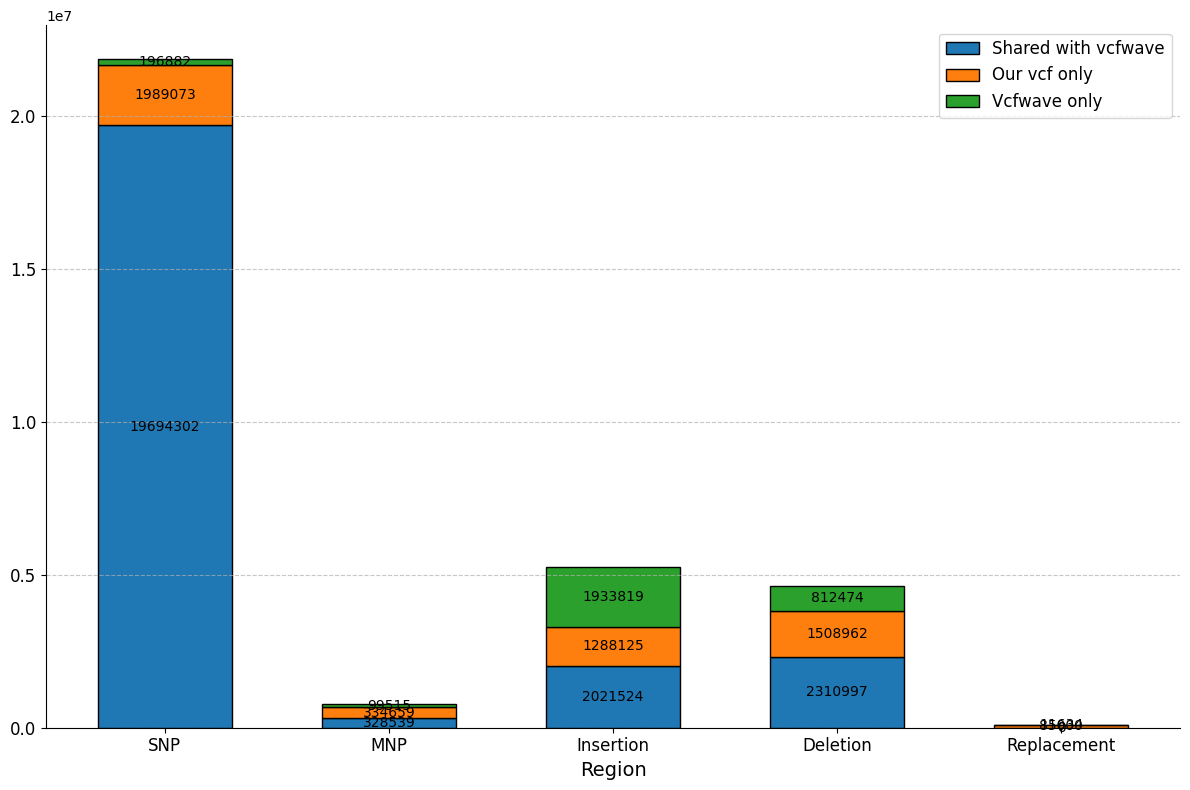

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the stacked bar chart
categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement']
data_stack1 = list(variant_type_df['shared'])  # Values for the first stack
data_stack2 = list(variant_type_df['our vcf only'])  # Values for the second stack
data_stack3 = list(variant_type_df['vcfwave only'])  # Values for the third stack

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(12, 8))

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Shared with vcfwave', edgecolor='black')
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Our vcf only', edgecolor='black')
plt.bar(x, data_stack3, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2), label='Vcfwave only', edgecolor='black')

# Annotate values on each stack
for i, value in enumerate(data_stack1):
    plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
for i, value in enumerate(data_stack2):
    bottom_value = data_stack1[i]
    plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2
for i, value in enumerate(data_stack3):
    bottom_value = data_stack1[i] + data_stack2[i]
    plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 3


# Add titles and labels
# plt.xlabel('Region', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/stacked_bar_chart_variant_type_vcfwave.pdf', dpi=600, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()



Chart: Variants in triallelic bubbles by type and whether in vcfwave

In [5]:
categories_ = ['snp', 'mnp', 'insertion', 'deletion', 'replacement', 'inversion', 'repeat', 'inversion_repeat']
categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Inversion&Repeat']
data = {
    'Category': categories,
    'our vcf': [0]*8,
    'shared with vcfwave': [0]*8
}

def is_var_type(x, var_type):
    info_dict = {attr.split('=')[0]: attr.split('=')[1] for attr in x.split(';') if '=' in attr}
    return info_dict['VT'] == var_type


for i in range(1,23):
    print(f"Processing chr{i}...")
    vcf_wave_path = f"{raw_vcf_dir}/hprc-v1.1-mc-grch38.vcfbub.a100k.wave_chr{i}.vcf"
    triallelic_var_path = f"{bubble_summary_dir}/triallelic_variants_chr{i}.tsv"

    vcf_wave_df = read_vcf_to_dataframe(vcf_wave_path)[['POS', 'REF', 'ALT', 'INFO']]
    triallelic_df = pd.read_csv(triallelic_var_path, sep='\t', dtype=str)[['POS', 'REF', 'ALT', 'INFO']]

    for category in categories_:
        triallelic_df_temp = triallelic_df[triallelic_df['INFO'].apply(lambda x: is_var_type(x, category))]
        shared_with_vcfwave = triallelic_df_temp.merge(vcf_wave_df, how='inner', on=['POS', 'REF', 'ALT'])
        count_our_vcf = len(triallelic_df_temp) - len(shared_with_vcfwave)
        count_shared = len(shared_with_vcfwave)
        data['our vcf'][categories_.index(category)] += count_our_vcf
        data['shared with vcfwave'][categories_.index(category)] += count_shared

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...


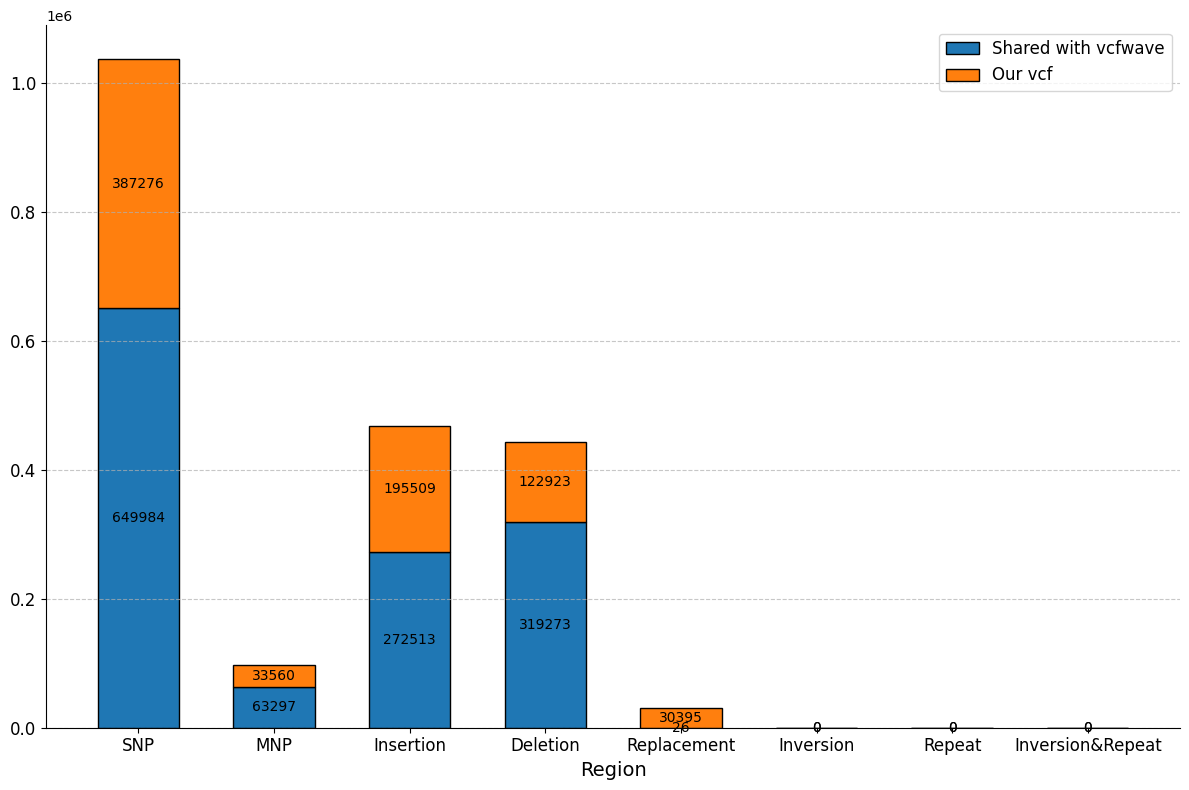

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the stacked bar chart
categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Inversion&Repeat']
data_stack1 = data['shared with vcfwave']  # Values for the first stack
data_stack2 = data['our vcf']  # Values for the second stack

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(12, 8))

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Shared with vcfwave', edgecolor='black')
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Our vcf', edgecolor='black')

# Annotate values on each stack
for i, value in enumerate(data_stack1):
    plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
for i, value in enumerate(data_stack2):
    bottom_value = data_stack1[i]
    plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2


# Add titles and labels
plt.xlabel('Region', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/triallelic_stacked_bar_chart_variant_type_vcfwave.pdf', dpi=600, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()



In [1]:
import pandas as pd

wavevcf = True

if wavevcf:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_wave_clear.xlsx'
else:
    file_path = '/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Data_visualization/data_chr_raw.xlsx'

sheets = pd.read_excel(file_path, sheet_name=None)

In [2]:
graph_vcf_summary_concated_df = sheets['variant_summary_with_NIA_flag']
region_concated_df = sheets['snp_region_summary']
range_concated_df = sheets['snp_ac_range_summary']

In [3]:
graph_vcf_summary_df = graph_vcf_summary_concated_df[graph_vcf_summary_concated_df['CHROM'] == 'all']
region_df = region_concated_df[region_concated_df['CHROM'] == 'all']
range_df = range_concated_df[range_concated_df['CHROM'] == 'all']

Chart: Large variants stacked by common or not

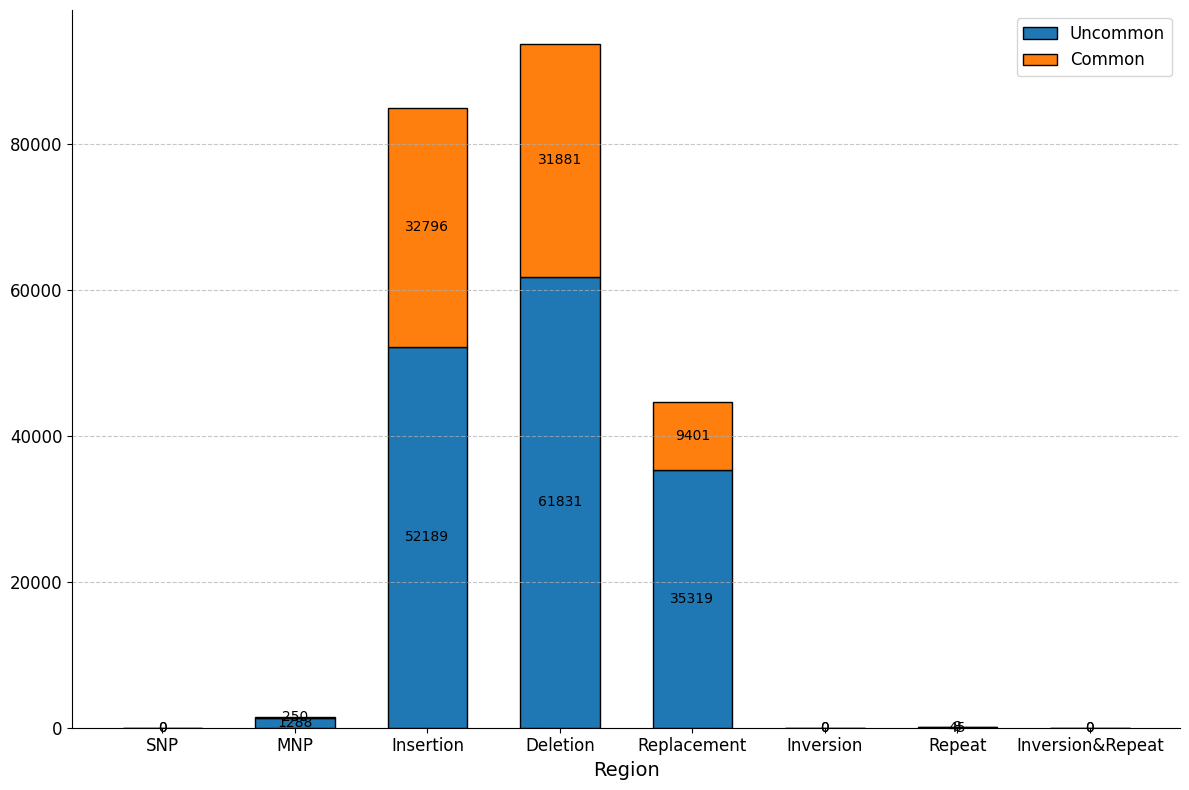

In [7]:
import matplotlib.pyplot as plt
import numpy as np

data_stack1_list = list(graph_vcf_summary_df['Large_Variants'] - graph_vcf_summary_df['Large_Common_Variants'])[:-1]
data_stack2_list = list(graph_vcf_summary_df['Large_Common_Variants'])[:-1]

# Data for the stacked bar chart
categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Inversion', 'Repeat', 'Inversion&Repeat']
data_stack1 = data_stack1_list  # Values for the first stack
data_stack2 = data_stack2_list # Values for the second stack

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(12, 8))

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Uncommon', edgecolor='black')
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Common', edgecolor='black')

# Annotate values on each stack
for i, value in enumerate(data_stack1):
    plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
for i, value in enumerate(data_stack2):
    bottom_value = data_stack1[i]
    plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2


# Add titles and labels
plt.xlabel('Region', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/stacked_bar_chart_large_variant_common_or_not.pdf', dpi=600, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()



Chart 1a: Small/Large Variant Bar

/tmp/ipykernel_15982/1906532011.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Small_Variants']),
/tmp/ipykernel_15982/1906532011.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Small_Variants']),
/tmp/ipykernel_15982/1906532011.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Small_Variants']),
/tmp/ipykernel_15982/1906532011.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) i

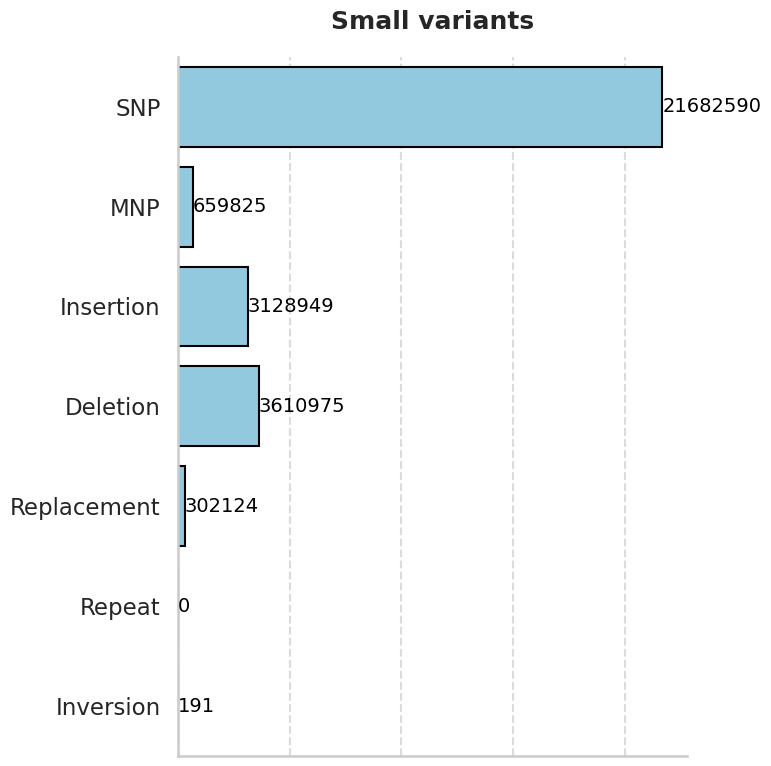

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Small_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Small_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Small_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Small_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Small_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Small_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Small_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Small variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')
#plt.gca().set_xticks([])

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/small_variant_horizontal_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()


/tmp/ipykernel_15982/3510892260.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Large_Variants']),
/tmp/ipykernel_15982/3510892260.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Large_Variants']),
/tmp/ipykernel_15982/3510892260.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Large_Variants']),
/tmp/ipykernel_15982/3510892260.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) i

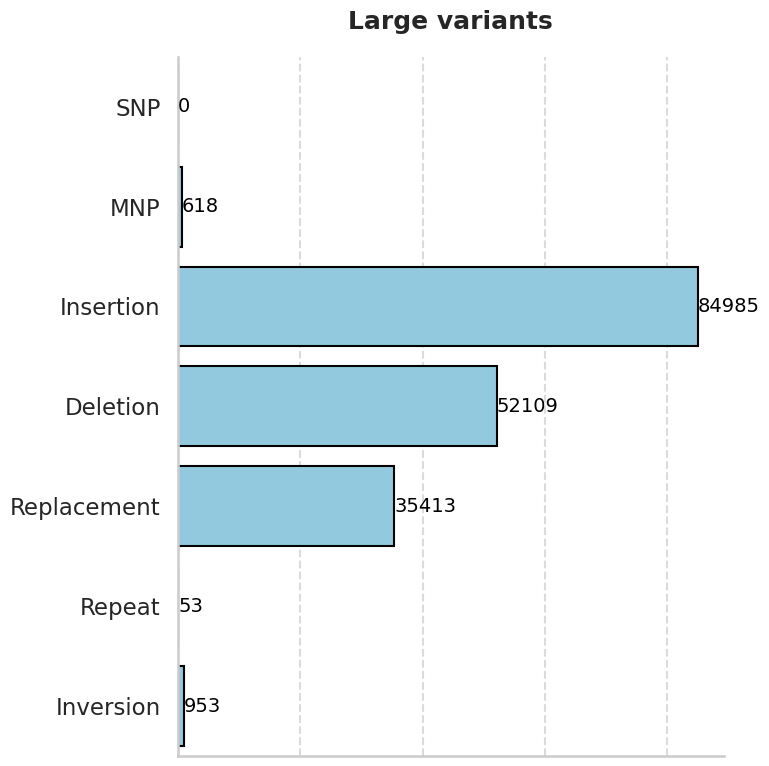

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Large_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Large_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Large_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Large variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/large_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()


In [76]:
wavevcf = False

Chart 1b: SNP By Region

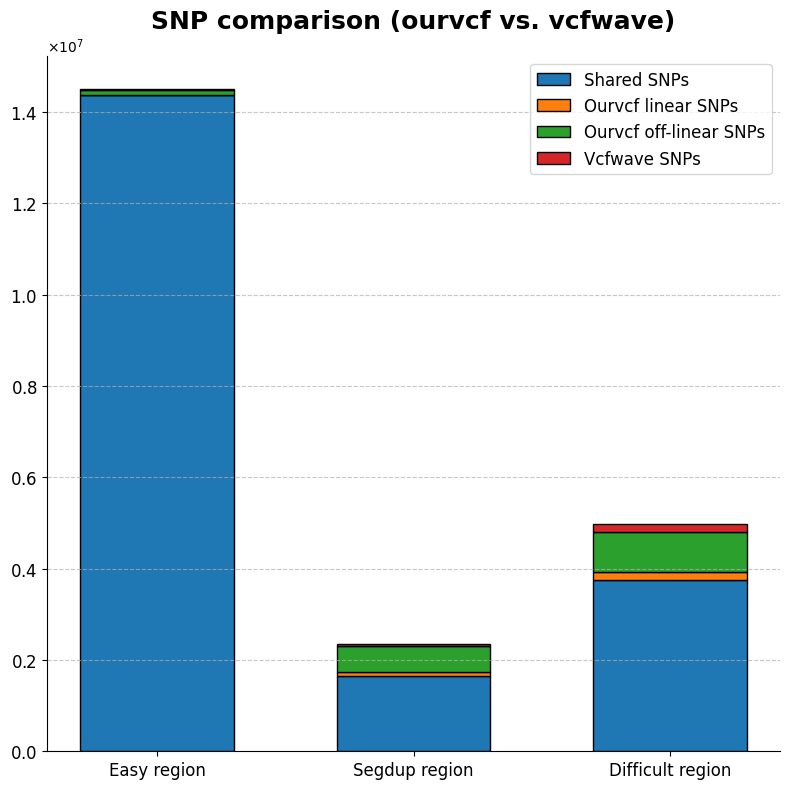

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import numpy as np

shared_count_list = region_df['Shared'].to_list()
ourlinear_count_list = region_df['Ourvcf_linear'].to_list()
ourofflinear_count_list = region_df['Ourvcf_offlinear'].to_list()
raw_count_list = region_df['Vcfwave_only'].to_list()

# Data for the stacked bar chart
categories = ['Easy region', 'Segdup region', 'Difficult region']  # n categories
data_stack1 = shared_count_list
data_stack2 = ourlinear_count_list
data_stack3 = ourofflinear_count_list
data_stack4 = raw_count_list

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(8, 8))

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Shared SNPs', edgecolor='black')
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Ourvcf linear SNPs', edgecolor='black')
plt.bar(x, data_stack3, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2), 
        label='Ourvcf off-linear SNPs', edgecolor='black')
plt.bar(x, data_stack4, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2) + np.array(data_stack3), 
        label='Vcfwave SNPs', edgecolor='black')

# Annotate values on each stack
# for i, value in enumerate(data_stack1):
#     plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
# for i, value in enumerate(data_stack2):
#     bottom_value = data_stack1[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2
# for i, value in enumerate(data_stack3):
#     bottom_value = data_stack1[i] + data_stack2[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 3

if wavevcf:
    plt.title('SNP comparison (ourvcf vs. vcfwave)', fontsize=18, weight='bold', pad=20)
else:
    plt.title('SNP comparison (ourvcf vs. rawvcf)', fontsize=18, weight='bold', pad=20)

# Add titles and labels
plt.xlabel('', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Apply scientific notation to the x-axis

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
if wavevcf:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_region.pdf', dpi=600, bbox_inches='tight', format='pdf')
else:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/raw_snp_stacked_bar_chart_all_chr_by_region.pdf', dpi=600, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()


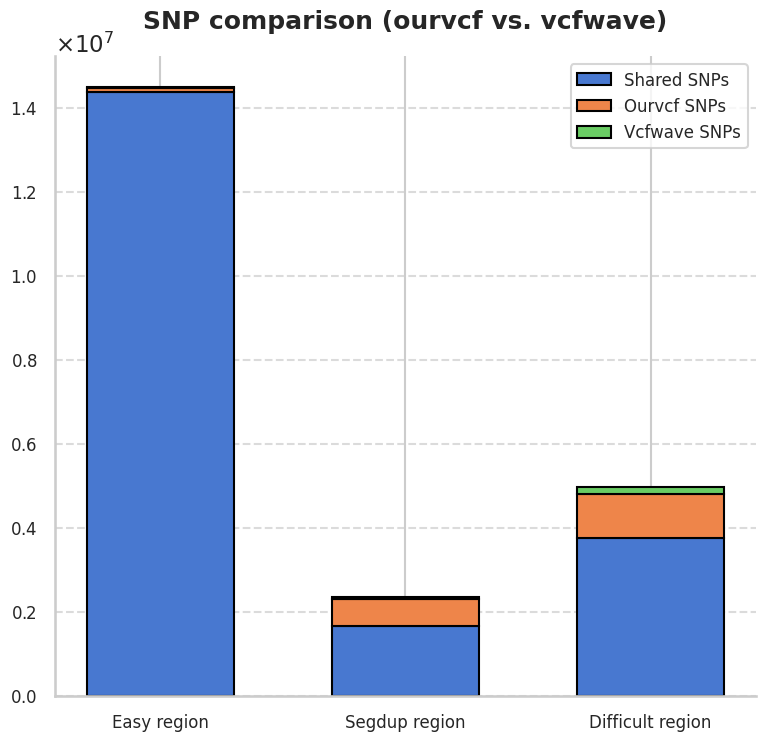

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import numpy as np

shared_count_list = region_df['Shared'].to_list()
our_count_list = region_df['Ourvcf_only'].to_list()
raw_count_list = region_df['Vcfwave_only'].to_list()

# Data for the stacked bar chart
categories = ['Easy region', 'Segdup region', 'Difficult region']  # n categories
data_stack1 = shared_count_list  # Values for the first stack
data_stack2 = our_count_list  # Values for the second stack
data_stack3 = raw_count_list  # Values for the third stack

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(8, 8))

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Shared SNPs', edgecolor='black')
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Ourvcf SNPs', edgecolor='black')
plt.bar(x, data_stack3, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2), 
        label='Vcfwave SNPs', edgecolor='black')

# Annotate values on each stack
# for i, value in enumerate(data_stack1):
#     plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
# for i, value in enumerate(data_stack2):
#     bottom_value = data_stack1[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2
# for i, value in enumerate(data_stack3):
#     bottom_value = data_stack1[i] + data_stack2[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 3

if wavevcf:
    plt.title('SNP comparison (ourvcf vs. vcfwave)', fontsize=18, weight='bold', pad=20)
else:
    plt.title('SNP comparison (ourvcf vs. rawvcf)', fontsize=18, weight='bold', pad=20)

# Add titles and labels
plt.xlabel('', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Apply scientific notation to the x-axis

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
if wavevcf:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_region.pdf', dpi=600, bbox_inches='tight', format='pdf')
else:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/raw_snp_stacked_bar_chart_all_chr_by_region.pdf', dpi=600, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()


Chart 1c: SNP By AC and Region in Segdup or Difficult

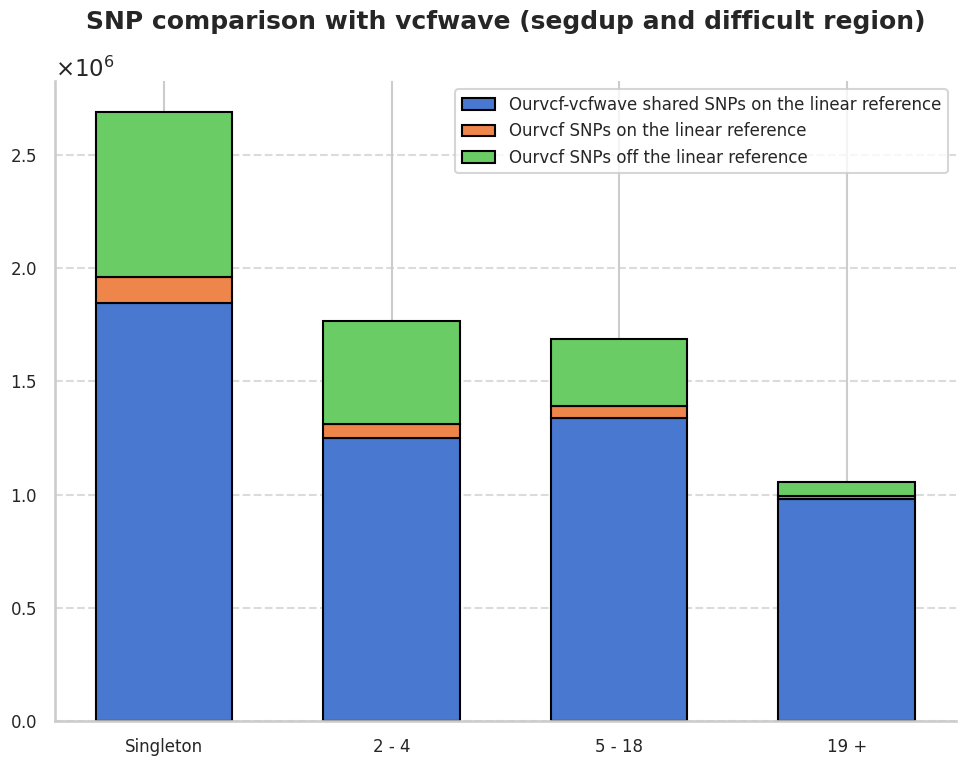

In [12]:
import matplotlib.pyplot as plt
import numpy as np

simple_count_list = range_df['Shared'].to_list()
complex_count_list = range_df['Ourvcf_linear'].to_list()
nonlinear_count_list = range_df['Ourvcf_offlinear'].to_list()

# Data for the stacked bar chart
categories = ['Singleton', '2 - 4', '5 - 18', '19 +']  # n categories
data_stack1 = simple_count_list  # Values for the first stack
data_stack2 = complex_count_list  # Values for the second stack
data_stack3 = nonlinear_count_list  # Values for the third stack

# Define bar positions and width
x = np.arange(len(categories))  # X positions for the bars
bar_width = 0.6

# Create the figure and axis
plt.figure(figsize=(10, 8))

# Create the stacked bars
plt.bar(x, data_stack1, width=bar_width, label='Ourvcf-vcfwave shared SNPs on the linear reference', edgecolor='black')
plt.bar(x, data_stack2, width=bar_width, bottom=data_stack1, label='Ourvcf SNPs on the linear reference', edgecolor='black')
plt.bar(x, data_stack3, width=bar_width, bottom=np.array(data_stack1) + np.array(data_stack2), 
        label='Ourvcf SNPs off the linear reference', edgecolor='black')

# Annotate values on each stack
# for i, value in enumerate(data_stack1):
#     plt.text(x[i], value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 1
# for i, value in enumerate(data_stack2):
#     bottom_value = data_stack1[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 2
# for i, value in enumerate(data_stack3):
#     bottom_value = data_stack1[i] + data_stack2[i]
#     plt.text(x[i], bottom_value + value / 2, str(value), ha='center', va='center', fontsize=10, color='black')  # Stack 3

if wavevcf:
    plt.title('SNP comparison with vcfwave (segdup and difficult region)', fontsize=18, weight='bold', pad=20)
else:
    plt.title('SNP comparison with raw vcf (segdup and difficult region)', fontsize=18, weight='bold', pad=20)

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Apply scientific notation to the x-axis

# Add titles and labels
# plt.xlabel('Allele count', fontsize=14)
# plt.ylabel('Count', fontsize=14)
plt.xticks(x, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, title_fontsize=14, loc='upper right')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the chart as a high-resolution image
if wavevcf:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/wave_snp_stacked_bar_chart_all_chr_by_ac_in_not_easy_region.pdf', dpi=600, bbox_inches='tight', format='pdf')
else:
    plt.savefig(f'/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/raw_snp_stacked_bar_chart_all_chr_by_ac_in_not_easy_region.pdf', dpi=600, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()


Chart 1d: Focus on off-linear variants

/tmp/ipykernel_15982/3877829628.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Variants']),
/tmp/ipykernel_15982/3877829628.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Variants']),
/tmp/ipykernel_15982/3877829628.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Variants']),
/tmp/ipykernel_15982/3877829628.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(

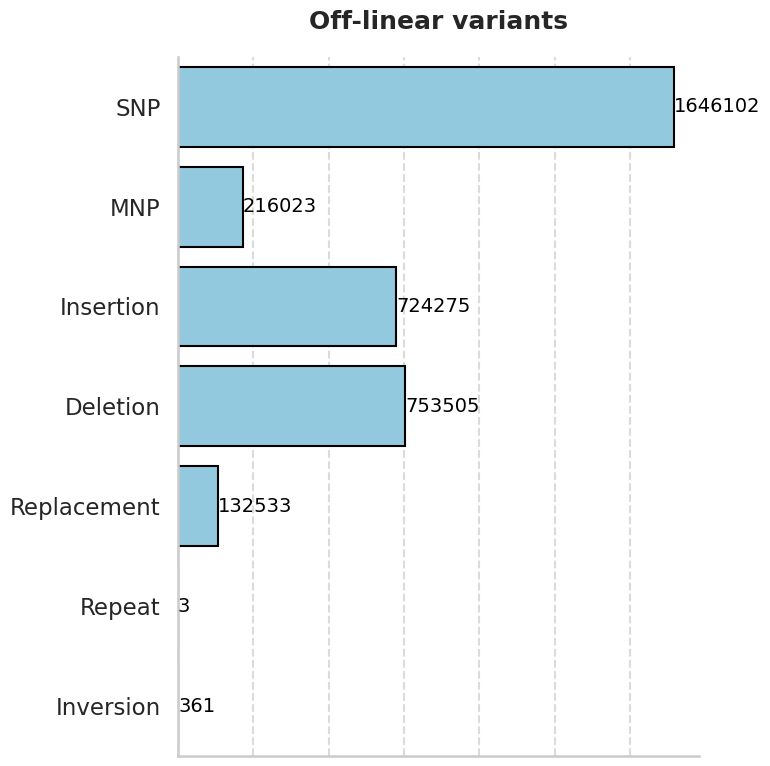

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Non_Linear_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Non_Linear_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Non_Linear_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Non_Linear_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Off-linear variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()


/tmp/ipykernel_15982/4214890813.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Large_Common_Variants']),
/tmp/ipykernel_15982/4214890813.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Large_Common_Variants']),
/tmp/ipykernel_15982/4214890813.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Large_Common_Variants']),
/tmp/ipykernel_15982/4214890813.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Us

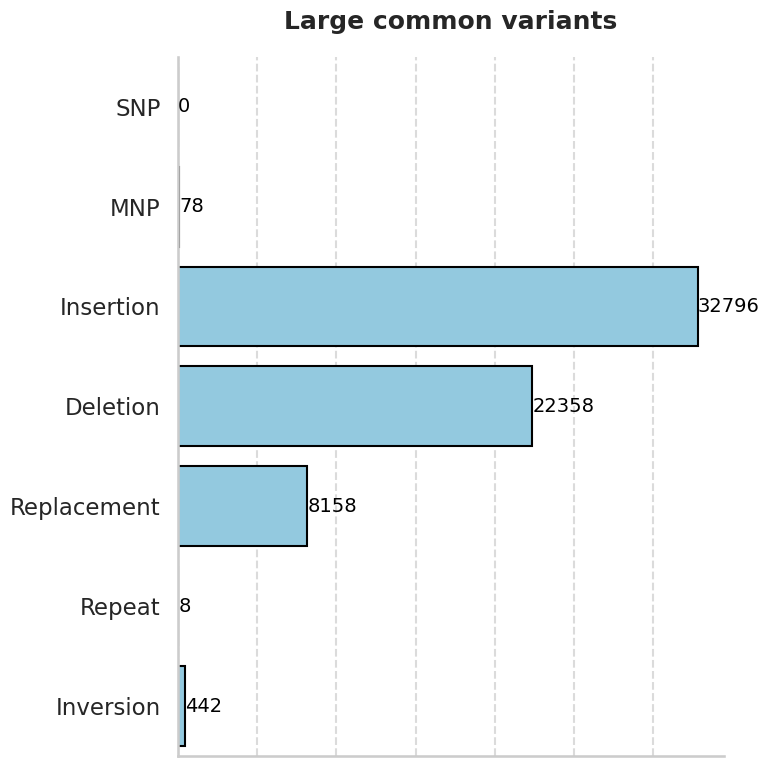

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Large_Common_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Large_Common_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Large_Common_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Large common variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

# Customize the x-axis to use scientific notation
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/large_common_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()


/tmp/ipykernel_15982/756356508.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Large_Variants']),
/tmp/ipykernel_15982/756356508.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Large_Variants']),
/tmp/ipykernel_15982/756356508.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Large_Variants']),
/tmp/ipykernel_15982/756356508.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the fu

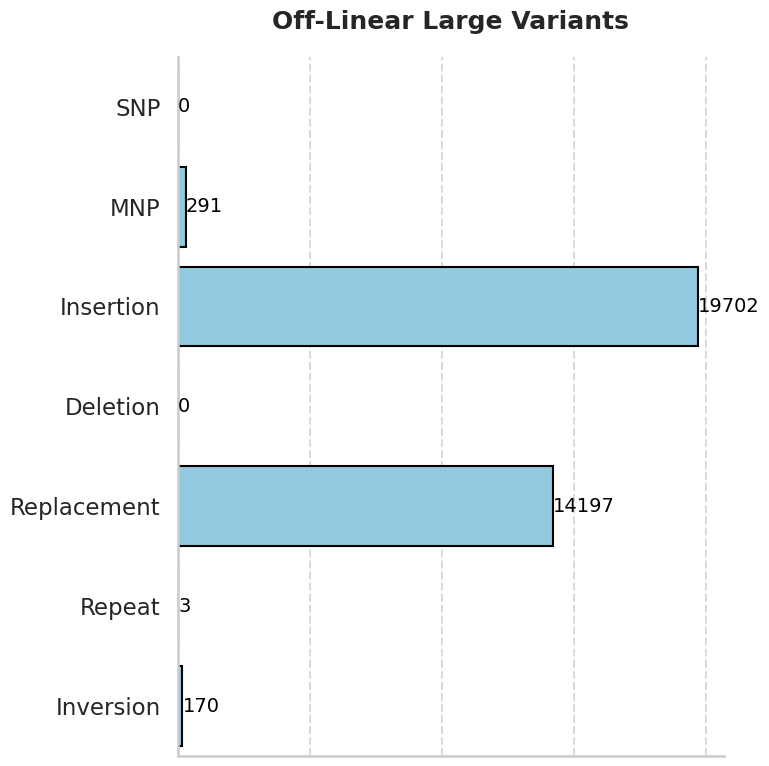

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Non_Linear_Large_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Non_Linear_Large_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Non_Linear_Large_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Non_Linear_Large_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Off-Linear Large Variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_large_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()


/tmp/ipykernel_15982/251746385.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Large_Common_Variants']),
/tmp/ipykernel_15982/251746385.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Large_Common_Variants']),
/tmp/ipykernel_15982/251746385.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Large_Common_Variants']),
/tmp/ipykernel_15982/251746385.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise 

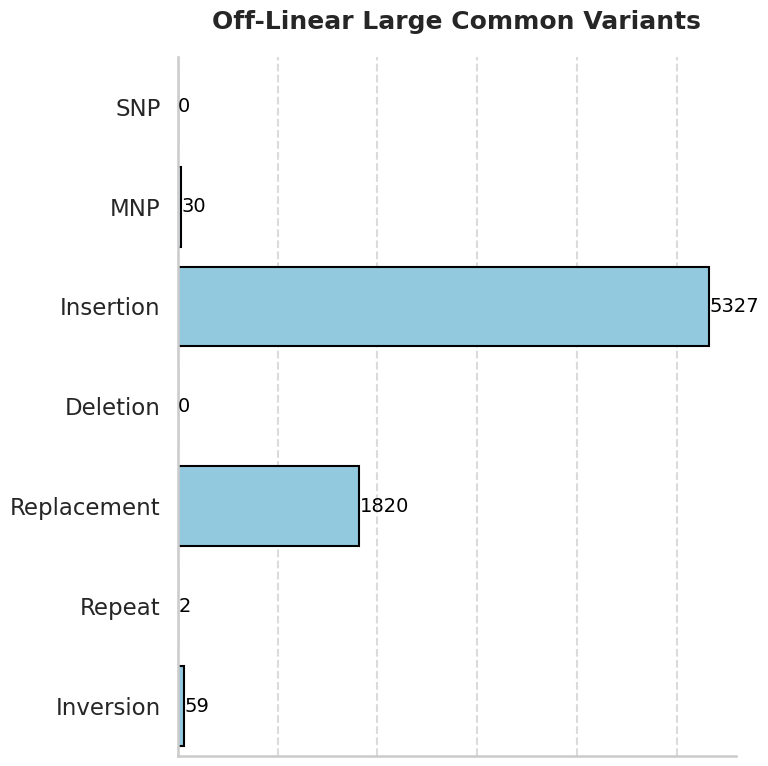

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

categories = ['SNP', 'MNP', 'Insertion', 'Deletion', 'Replacement', 'Repeat', 'Inversion']
values = [int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'SNP']['Non_Linear_Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'MNP']['Non_Linear_Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Insertion']['Non_Linear_Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Deletion']['Non_Linear_Large_Common_Variants']), 
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Replacement']['Non_Linear_Large_Common_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Repeat']['Non_Linear_Large_Common_Variants']),
          int(graph_vcf_summary_df[graph_vcf_summary_df['Variant Type'] == 'Inversion']['Non_Linear_Large_Common_Variants'])]

# Data
data = pd.DataFrame({
    'Category': categories,
    'Count': values
})

# Set a professional style
sns.set_theme(style="whitegrid", palette="muted", context="talk")

#data = data.sort_values(by='Count', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 8))  # Set the figure size
sns.barplot(y='Category', x='Count', data=data, edgecolor='black', color="skyblue")

# Add titles and labels
plt.title('Off-Linear Large Common Variants', fontsize=18, weight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')

ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # Apply scientific notation to the x-axis
ax.set_xticklabels([])
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Customize the grid and remove top/right spines for a cleaner look
sns.despine(left=False, bottom=False)

# Add value labels next to bars
for i, v in enumerate(data['Count']):
    plt.text(v + 2, i, f"{v}", va='center', fontsize=14, color='black')

# Show the plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/offlinear_large_common_variant_bar_chart_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()


Chart 1e: Histogram for bubbles with 3 alleles and 3+ alleles

In [4]:
ac_dir = "/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Bubble_result_update"

df_list = []
for i in range(1,23):
    ac_df_path = f"{ac_dir}/bubble_allele_summary_chr{i}.tsv"
    ac_df = pd.read_csv(ac_df_path, sep='\t')
    df_list.append(ac_df)

concated_df = pd.concat(df_list)
concated_df.to_csv(f"{ac_dir}/bubble_allele_summary_all_chr.tsv", index=False, sep='\t')

In [9]:
concated_df = pd.read_csv(f"{ac_dir}/bubble_allele_summary_all_chr.tsv", sep='\t')

variant_df = concated_df[concated_df['num_variants'].apply(lambda x: x >= 2)]
allele_df = concated_df[concated_df['allele_count_vcf'].apply(lambda x: x >= 2)]

variant_data = variant_df['num_variants'].to_numpy()
allele_data = allele_df['allele_count_vcf'].to_numpy()

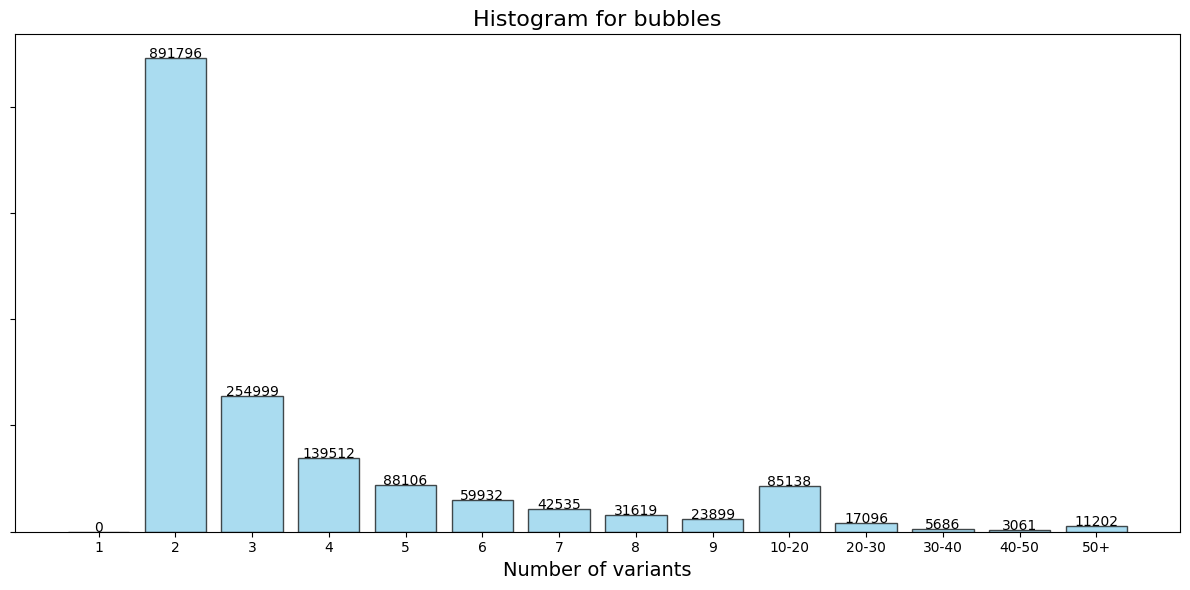

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = variant_data  # Generate some data between 0 and 60

# Define custom bins
bins = list(range(1, 11)) + [20, 30, 40, 50] + [float('inf')]

# Adjust labels for each bin
bin_labels = [f"{i}" for i in range(1, 10)] + ["10-20", "20-30", "30-40", "40-50", "50+"]

# Compute histogram
counts, bin_edges = np.histogram(data, bins=bins)

# Create bar positions
bar_positions = np.arange(len(counts))

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(bar_positions, counts, edgecolor="black", alpha=0.7, color="skyblue")

# Add custom x-axis labels
plt.xticks(bar_positions, bin_labels, fontsize=10)

# Add titles and labels
plt.title("Histogram for bubbles", fontsize=16)
plt.xlabel("Number of variants", fontsize=14)
#plt.ylabel("Frequency", fontsize=14)

ax = plt.gca()  # Get the current axes
ax.set_yticklabels([])
#ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Annotate bar counts
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha="center", fontsize=10)

# Show plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_num_vars_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()

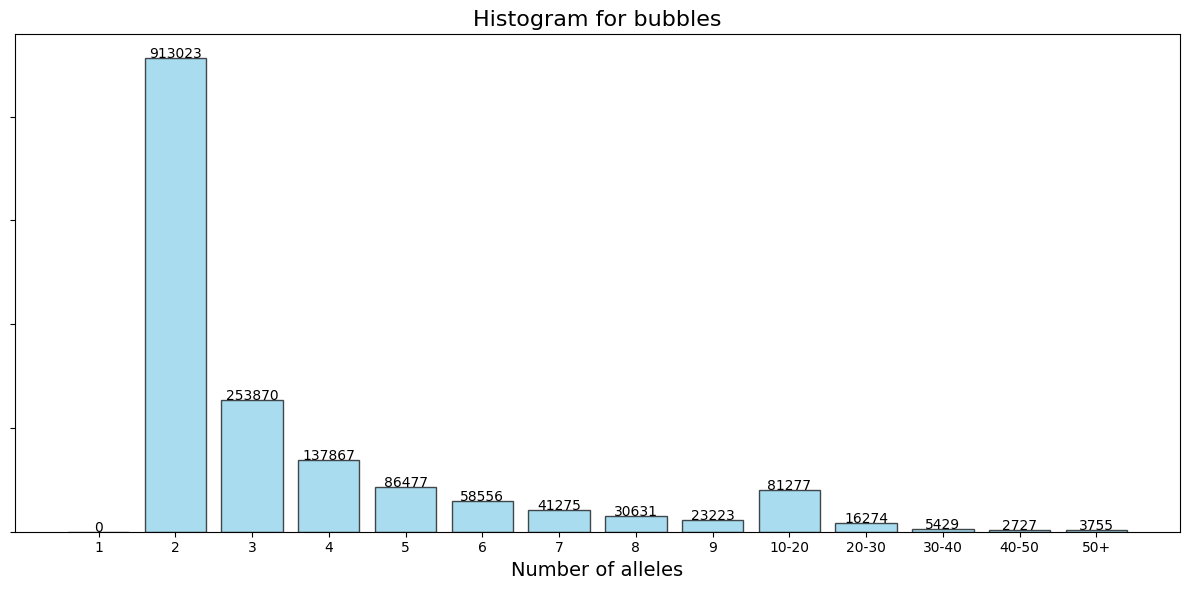

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = allele_data  # Generate some data between 0 and 60

# Define custom bins
bins = list(range(1, 11)) + [20, 30, 40, 50] + [float('inf')]

# Adjust labels for each bin
bin_labels = [f"{i}" for i in range(1, 10)] + ["10-20", "20-30", "30-40", "40-50", "50+"]

# Compute histogram
counts, bin_edges = np.histogram(data, bins=bins)

# Create bar positions
bar_positions = np.arange(len(counts))

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(bar_positions, counts, edgecolor="black", alpha=0.7, color="skyblue")

# Add custom x-axis labels
plt.xticks(bar_positions, bin_labels, fontsize=10)

# Add titles and labels
plt.title("Histogram for bubbles", fontsize=16)
plt.xlabel("Number of alleles", fontsize=14)
#plt.ylabel("Frequency", fontsize=14)

ax = plt.gca()  # Get the current axes
ax.set_yticklabels([])

# Annotate bar counts
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha="center", fontsize=10)

# Show plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/histogram_num_alleles_all_chr.pdf', dpi=600, bbox_inches='tight', format='pdf')

plt.show()

Chart 1f: Scatter plot for bubbles on num_variant vs num_allele

In [ ]:
df_list = []
for i in range(1,23):
    ac_df_path = f"{ac_dir}/bubble_allele_summary_chr{i}.tsv"
    ac_df = pd.read_csv(ac_df_path, sep='\t')
    df_list.append(ac_df)

concated_df = pd.concat(df_list)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = concated_df['num_variants'].to_numpy()
y = concated_df['allele_count_vcf'].to_numpy()

# Scatter plot
plt.figure(figsize=(20, 10))  # Set figure size
plt.scatter(x, y, color="blue", s=10, alpha=0.6)

# Set equal axis limits
min_range = 0
max_range = min(x.max(), y.max())
# min_range = 0
# max_range = 1000
plt.xlim(min_range, 2*max_range)
plt.ylim(min_range, max_range)

# Add y = x line
plt.plot([min_range, max_range], [min_range, max_range], color="red", linestyle="--", linewidth=1)

# Add labels, title, and legend
# plt.title("Scatter plot for bubbles", fontsize=16, pad=20)
plt.xlabel("Number of variant edges", fontsize=14)
plt.ylabel("Number of alleles in raw vcf", fontsize=14)

# Add grid for better visualization
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.tight_layout()

# Save the chart as a high-resolution image
plt.savefig('/n/data1/hms/dbmi/oconnor/lab/shz311/pangenome/Charts/1f_scatter_num_var_num_allele_all_chr.png', dpi=600)

plt.show()
